In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
import matplotlib

In [2]:
df = pd.read_csv("data/contamination_fracking.csv")
df.dropna(inplace=True)
df = df[~df['State'].apply(lambda x: str(x).isdigit())] # in some cases State is reported as a number
df.head()

,Unnamed: 0,level_0,CollectionDate,FacilityID,State,ContaminantCount,index,FacilityWaterType,Zip,LatitudePWS,...,PercentHighAdditive,PercentHFJob,IngredientName,Purpose,Supplier,JobDuration,TotalBaseWaterVolume,TotalBaseNonWaterVolume,distance_nearest,distance_20_nearest
1,1,13420,2014-02-06,1,CA,28,67540,SW,91802,33.786594,...,30.000000,1.729810,"('Ethoxylated Alcohol', 'Sodium Aryl Sulfonate...","('Surfactant', 'Non-emulsifier', 'Scale Inhibi...","('Baker Hughes', 'Other Chemicals', 'Operator')",1.0,287133.0,0.0,11.066041,11.722878
4,4,13423,2014-02-06,1,FL,28,89596,GW,32353,30.549676,...,36.573585,1.897712,"('Aluminum Oxide', 'Ethylene Glycol', 'Ethoxyl...","('Cross-linkers', 'Bulk Acid', 'Acid Corrosion...","('SAGA PETROLEUM', 'Nabors Completion and Prod...",0.0,53000.0,0.0,4.053320,7.282085
5,5,13424,2014-02-06,1,MA,21,55442,GW,1720,42.477142,...,27.013514,2.688290,"('Hydrochloric Acid', 'Alcohol Ethoxylate', 'C...","('Friction Reducer', 'Non-Emulsifier', 'Iron C...","('Chemplex', 'Reagent', 'TSS', 'Rain for Rent')",15.0,12878460.0,0.0,4.174925,4.437170
6,6,13425,2014-02-06,1,MD,26,50446,SW,21078,39.554644,...,32.940000,2.857143,('Potassium salt of diethylene triamine penta ...,"('Bulk Acid', 'Friction Reducer', 'Proppant', ...","('U.S. Well Services, LLC', 'Inflection Energy...",5.0,6132042.0,0.0,1.922339,2.061130
7,7,13426,2014-02-06,1,MN,21,39511,SW,55427,45.006764,...,23.654167,4.147837,"('Alkyl amine salts', '2,2-dibromo-3-nitrilopr...","('Scale Inhibitor', 'Flowback Enhancer', 'Othe...","(nan, 'Trican', 'Customer')",1.0,90509.0,0.0,8.230094,8.549826


In [3]:
print(df.columns)
print(df.shape)
print(df.State.unique())
print(df.groupby('State', as_index=False)['distance_nearest'].mean())
print(df.groupby('State', as_index=False)['distance_20_nearest'].mean())
dftmp = df.groupby('State', as_index=False)['distance_20_nearest'].mean()
states_common = dftmp[dftmp['distance_20_nearest'] <2 ].State.unique()
states_sparse = dftmp[dftmp['distance_20_nearest'] >=2 ].State.unique()
print(states_common)
print(states_sparse)


Index(['Unnamed: 0', 'level_0', 'CollectionDate', 'FacilityID', 'State',
       'ContaminantCount', 'index', 'FacilityWaterType', 'Zip', 'LatitudePWS',
       'LongitudePWS', 'IsContaminated', 'SizeBool', 'sampleId', 'geometry',
       'LatitudeFracking', 'LongitudeFracking', 'JobEndDate',
       'PercentHighAdditive', 'PercentHFJob', 'IngredientName', 'Purpose',
       'Supplier', 'JobDuration', 'TotalBaseWaterVolume',
       'TotalBaseNonWaterVolume', 'distance_nearest', 'distance_20_nearest'],
      dtype='object')
(23500, 28)
['CA' 'FL' 'MA' 'MD' 'MN' 'NC' 'NE' 'NH' 'NY' 'OR' 'PA' 'TN' 'UT' 'VI'
 'VT' 'WA' 'WI' 'CO' 'KS' 'RI' 'ID' 'SD' 'AR' 'HI' 'AZ' 'GA' 'KY' 'IA'
 'VA' 'TX' 'NJ' 'NV' 'ME' 'SC' 'ND' 'MT' 'DE' 'WV' 'MI' 'LA' 'NM' 'AL'
 'MO' 'IN' 'IL' 'OK' 'CT' 'OH' 'MS' 'AK' 'WY' 'PR' 'NN' 'AS']
   State  distance_nearest
0     AK         43.885362
1     AL          1.196160
2     AR          0.666612
3     AS         76.471819
4     AZ          5.093664
5     CA         11.832887


In [4]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
df_ohe = df.copy()
#print(df_ohe.columns)
#df_ohe = df_ohe[df_ohe.State.isin(states_common)]
#print(type(df_ohe))
for col in ['FacilityWaterType','State']:
    ohe = pd.get_dummies(df_ohe[col], prefix='{}'.format(col))
    df_ohe = df_ohe.drop(col, 1) # drop the column that we are OHE-ing
    df_ohe = pd.concat([df_ohe.reset_index(drop=True), ohe.reset_index(drop=True)], axis=1)
print(df_ohe.shape)

(23500, 84)


In [5]:
df_ohe = df_ohe.drop(['Unnamed: 0', # artifact of KNN
                      'level_0', # artifact of merging
                      'index', # artifact of merging
                      'sampleId', # artifact of EDA
                      'geometry', # artifact of KNN
                      'JobEndDate', # will use duration instead of end date
                      'IngredientName', # not currently encoding this
                      'Zip', # not currently encoding this
                      'CollectionDate', # do not need this
                      'Supplier', # not currently encoding this
                      'Purpose', # not currently encoding this 
                     ], axis=1)
print(df_ohe.columns)
df_ohe.head()

Index(['FacilityID', 'ContaminantCount', 'LatitudePWS', 'LongitudePWS',
       'IsContaminated', 'SizeBool', 'LatitudeFracking', 'LongitudeFracking',
       'PercentHighAdditive', 'PercentHFJob', 'JobDuration',
       'TotalBaseWaterVolume', 'TotalBaseNonWaterVolume', 'distance_nearest',
       'distance_20_nearest', 'FacilityWaterType_GU', 'FacilityWaterType_GW',
       'FacilityWaterType_MX', 'FacilityWaterType_SW', 'State_AK', 'State_AL',
       'State_AR', 'State_AS', 'State_AZ', 'State_CA', 'State_CO', 'State_CT',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NN', 'State_NV', 'State_NY', 'State_OH', 'State_OK',
       'State_OR', 'State_PA', 'State_PR', 'State_RI', 'State_SC', 'State_SD',
 

,FacilityID,ContaminantCount,LatitudePWS,LongitudePWS,IsContaminated,SizeBool,LatitudeFracking,LongitudeFracking,PercentHighAdditive,PercentHFJob,...,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY
0,1,28,33.786594,-118.298662,1,0,36.200230,-107.499050,30.000000,1.729810,...,0,0,0,0,0,0,0,0,0,0
1,1,28,30.549676,-84.606864,0,0,33.406510,-87.482260,36.573585,1.897712,...,0,0,0,0,0,0,0,0,0,0
2,1,21,42.477142,-71.442200,0,0,41.812000,-75.563800,27.013514,2.688290,...,0,0,0,0,0,0,0,0,0,0
3,1,26,39.554644,-76.111180,0,0,41.312447,-76.889328,32.940000,2.857143,...,0,0,0,0,0,0,0,0,0,0
4,1,21,45.006764,-93.382230,0,0,48.960520,-100.600420,23.654167,4.147837,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, TensorDataset
import tqdm 
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from ipywidgets import IntProgress
from sklearn import preprocessing

df_ohe['CCCategory'] = df_ohe.apply(lambda row: 6 if row.ContaminantCount > 30 else row.ContaminantCount//6, axis=1)
y = df_ohe['CCCategory'].values
output_dim = len(df_ohe['CCCategory'].unique())
df_ohe = df_ohe.drop(['CCCategory'], axis=1)
#y = df_ohe['ContaminantCount'].values
print(type(y))
X = df_ohe.loc[:, df_ohe.columns != 'ContaminantCount'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

<class 'numpy.ndarray'>


# Neural Network

In [9]:
#torch_tensor_cc = torch.tensor(df_ohe['ContaminantCount'].values)
#torch_tensor_vec = torch.from_numpy(df_ohe.loc[:, df_ohe.columns != 'ContaminantCount'].to_numpy())
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
tensor_X_train = torch.tensor(X_train)
tensor_y_train = torch.tensor(y_train)
tensor_X_test = torch.tensor(X_test)
tensor_y_test = torch.tensor(y_test)

In [10]:
print(df_ohe.shape)
print(tensor_X_train.shape)
print(tensor_X_test.shape)
print(tensor_y_train.shape)
print(tensor_y_test.shape)

(23500, 73)
torch.Size([15745, 72])
torch.Size([7755, 72])
torch.Size([15745])
torch.Size([7755])


In [39]:
train_dataset = TensorDataset(tensor_X_train, tensor_y_train) 
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [28]:
class FFNN(nn.Module):
    def __init__(self, input_dim, h, output_dim): #input_dim=len(vocab),h=512,output_dim=len(emoticons)
        super(FFNN, self).__init__()
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation1 = nn.ReLU() # The rectified linear unit; one valid choice of activation function
        self.W2 = nn.Linear(h, output_dim) 
        self.activation2 = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss()
    
    def forward(self, input_vector):
        z1 = self.W1(input_vector.float())
        z2 = self.activation1(z1)
        z3 = self.W2(z2)
        #print('Softmax: {}'.format(str(self.softmax(z3))))
        #print(z1)
        #print(z2)
        #print(z3)
        return self.activation2(z3)
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label.long())
    
    def load_model(self, save_path):
        self.load_state_dict(torch.load(save_path))

    def save_model(self, save_path):
        torch.save(self.state_dict(), save_path)

def train_epoch(model, train_loader, optimizer):
    model.train()
    iters = 0
    loss = 0.0
    running_loss = 0
    running_accuracy = 0
    for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
        output = model(input_batch)
        predicted = output.argmax(dim=1,keepdim=True)
        optimizer.zero_grad()
        loss = model.compute_loss(output, expected_out)
        acc = np.true_divide(predicted.squeeze(1).eq(expected_out).sum(),len(expected_out))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += acc.item()
        iters +=1
        #print(running_loss)
    print('Training Loss: {}'.format(running_loss/iters))
    print('Training Accuracy: {}'.format(running_accuracy/iters))
    
def evaluation(model, test_loader, optimizer):
    model.eval()
    iters = 0
    loss = 0.0
    running_loss = 0
    running_accuracy = 0
    for (input_batch, expected_out) in tqdm(test_loader, leave=False, desc="Testing Batches"):
        output = model(input_batch)
        predicted = output.argmax(dim=1,keepdim=True)
        loss = model.compute_loss(output, expected_out)
        acc = np.true_divide(predicted.squeeze(1).eq(expected_out).sum(),len(expected_out))
        running_loss += loss.item()
        running_accuracy += acc.item()
        iters +=1
        #print(running_loss)
    print('Testing Loss: {}'.format(running_loss/iters))
    print('Testing Accuracy: {}'.format(running_accuracy/iters))
    
def train_and_evaluate(number_of_epochs, model, train_loader, val_loader):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in trange(number_of_epochs, desc="Epochs"):
        train_epoch(model, train_loader, optimizer)
        evaluation(model, val_loader, optimizer)


In [29]:
h = 120
model = FFNN(72, h, output_dim) # 72 is num of features
train_and_evaluate(30, model, train_dataloader, test_dataloader)

Training Loss: 1.5624137500236774
Training Accuracy: 0.3743661257606491


Testing Loss: 1.4139223206680989
Testing Accuracy: 0.4081088664421998


Training Loss: 1.3842827487910736
Training Accuracy: 0.46190415821501013


Testing Loss: 1.35682308575744
Testing Accuracy: 0.4804059109614665


Training Loss: 1.3397561420533526
Training Accuracy: 0.4870055780933063


Testing Loss: 1.3198979931113162
Testing Accuracy: 0.5057402731013841


Training Loss: 1.3105787412390022
Training Accuracy: 0.509001014198783


Testing Loss: 1.2951114216949715
Testing Accuracy: 0.5146020389075945


Training Loss: 1.2906788830583042
Training Accuracy: 0.5155933062880325


Testing Loss: 1.2774954990104392
Testing Accuracy: 0.5189744668911336


Training Loss: 1.2758930405303381
Training Accuracy: 0.521551724137931


Testing Loss: 1.2641998058483925
Testing Accuracy: 0.5268191170968949


Training Loss: 1.2642324760284191
Training Accuracy: 0.5251014198782962


Testing Loss: 1.2536973769282118
Testing Accuracy: 0.5296483352038908


Training Loss: 1.2545674062403898
Training Accuracy: 0.526369168356998


Testing Loss: 1.2450063275211634
Testing Accuracy: 0.5304199401421624


Training Loss: 1.2462862017913958
Training Accuracy: 0.5284609533468559


Testing Loss: 1.2375915092205314
Testing Accuracy: 0.5309343434343435


Training Loss: 1.2390169282472159
Training Accuracy: 0.5273833671399595


Testing Loss: 1.2311154670185513
Testing Accuracy: 0.5313201459034793


Training Loss: 1.2325342341078707
Training Accuracy: 0.5276369168356998


Testing Loss: 1.2254193523293169
Testing Accuracy: 0.5327347549569772


Training Loss: 1.2267102107073182
Training Accuracy: 0.52776369168357


Testing Loss: 1.2203321449550582
Testing Accuracy: 0.5328633557800225


Training Loss: 1.2214275102828145
Training Accuracy: 0.5287778904665315


Testing Loss: 1.2157606560997511
Testing Accuracy: 0.5329919566030678


Training Loss: 1.2166042106630353
Training Accuracy: 0.5287778904665315


Testing Loss: 1.2116395507329776
Testing Accuracy: 0.5332491582491583


Training Loss: 1.2122104682980397
Training Accuracy: 0.5296653144016227


Testing Loss: 1.2079285925307883
Testing Accuracy: 0.5322203516647962


Training Loss: 1.2082048306358755
Training Accuracy: 0.5308062880324543


Testing Loss: 1.2045721737936201
Testing Accuracy: 0.5329919566030678


Training Loss: 1.2045390996439704
Training Accuracy: 0.5320106490872211


Testing Loss: 1.2015395169395477
Testing Accuracy: 0.5333894500561168


Training Loss: 1.2011694171849419
Training Accuracy: 0.5344193711967545


Testing Loss: 1.198769288543811
Testing Accuracy: 0.5336466517022073


Training Loss: 1.1980693435814027
Training Accuracy: 0.5370182555780934


Testing Loss: 1.1962514980830283
Testing Accuracy: 0.5357042648709316


Training Loss: 1.195207988091463
Training Accuracy: 0.5386029411764706


Testing Loss: 1.1939407861772389
Testing Accuracy: 0.5366044706322485


Training Loss: 1.1925476052577306
Training Accuracy: 0.5394903651115619


Testing Loss: 1.1917996102399786
Testing Accuracy: 0.5366044706322485


Training Loss: 1.1900650753089912
Training Accuracy: 0.5408215010141988


Testing Loss: 1.1898217448972381
Testing Accuracy: 0.5385334829779275


Training Loss: 1.1877677982888406
Training Accuracy: 0.5419624746450304


Testing Loss: 1.187992764107975
Testing Accuracy: 0.5394336887392444


Training Loss: 1.1856215993361832
Training Accuracy: 0.543040060851927


Testing Loss: 1.1862844876301142
Testing Accuracy: 0.5396908903853349


Training Loss: 1.183611528203647
Training Accuracy: 0.5435471602434077


Testing Loss: 1.1846957162574485
Testing Accuracy: 0.5396908903853349


Training Loss: 1.1817196079852856
Training Accuracy: 0.5435471602434077


Testing Loss: 1.1832001189636105
Testing Accuracy: 0.5391764870931538


Training Loss: 1.179931712803444
Training Accuracy: 0.5440542596348884


Testing Loss: 1.181769747547652
Testing Accuracy: 0.5390478862701086


Training Loss: 1.1782311368544736
Training Accuracy: 0.5442444219066938


Testing Loss: 1.1803984661651736
Testing Accuracy: 0.538790684624018


Training Loss: 1.1765941533186373
Training Accuracy: 0.5446247464503042


Testing Loss: 1.1790906907109076
Testing Accuracy: 0.538790684624018


Training Loss: 1.1750371850890997
Training Accuracy: 0.544434584178499


Testing Loss: 1.1777918370662894
Testing Accuracy: 0.5385334829779275



# Decision Tree Classifier

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=2900,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9502699269609399
Accuracy: 0.7311411992263056


# Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=1600,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9306446490949508
Accuracy: 0.7773049645390071


# PCA

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=2900,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("DT Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("DT Accuracy:", metrics.accuracy_score(y_test, y_pred))

clf = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=1600,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("RF Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("RF Accuracy:", metrics.accuracy_score(y_test, y_pred))

DT Accuracy: 0.9751032073674182
DT Accuracy: 0.6879432624113475
RF Accuracy: 0.9717370593839314
RF Accuracy: 0.7356544165054804


In [40]:
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
tensor_X_train = torch.tensor(X_train)
tensor_y_train = torch.tensor(y_train)
tensor_X_test = torch.tensor(X_test)
tensor_y_test = torch.tensor(y_test)
train_dataset = TensorDataset(tensor_X_train, tensor_y_train) 
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [42]:
h = 120
model = FFNN(50, h, output_dim) # 72 is num of features
train_and_evaluate(30, model, train_dataloader, test_dataloader)

Training Loss: 1.3158063087483443
Training Accuracy: 0.4808510638297872


Testing Loss: 1.228442894797568
Testing Accuracy: 0.5249516441005803


Training Loss: 1.232364973777928
Training Accuracy: 0.5201651317878692


Testing Loss: 1.1982564906279245
Testing Accuracy: 0.5390070921985816


Training Loss: 1.2078908465010054
Training Accuracy: 0.5323594791997459


Testing Loss: 1.180022254993576
Testing Accuracy: 0.5427466150870406


Training Loss: 1.1882054375987956
Training Accuracy: 0.5446173388377262


Testing Loss: 1.165661074614079
Testing Accuracy: 0.5472598323662153


Training Loss: 1.1713360641808235
Training Accuracy: 0.5524293426484598


Testing Loss: 1.1518583970404994
Testing Accuracy: 0.5531914893617021


Training Loss: 1.1574535841632738
Training Accuracy: 0.5571927596062242


Testing Loss: 1.144441873964996
Testing Accuracy: 0.5570599613152805


Training Loss: 1.1463053878887697
Training Accuracy: 0.5602413464591934


Testing Loss: 1.133529243181591
Testing Accuracy: 0.560541586073501


Training Loss: 1.1374097114403443
Training Accuracy: 0.5619561765639886


Testing Loss: 1.1272917700180847
Testing Accuracy: 0.5650548033526757


Training Loss: 1.1297800382933434
Training Accuracy: 0.5664655446173389


Testing Loss: 1.125663690273797
Testing Accuracy: 0.5650548033526757


Training Loss: 1.1240745268932464
Training Accuracy: 0.5684344236265481


Testing Loss: 1.1178674441779681
Testing Accuracy: 0.5691811734364925


Training Loss: 1.1191410442954417
Training Accuracy: 0.5706573515401715


Testing Loss: 1.1118842673687916
Testing Accuracy: 0.5742101869761445


Training Loss: 1.1128541001850705
Training Accuracy: 0.5735789139409336


Testing Loss: 1.1090934187558141
Testing Accuracy: 0.5757575757575758


Training Loss: 1.108126755245444
Training Accuracy: 0.5759923785328676


Testing Loss: 1.106147062618989
Testing Accuracy: 0.5775628626692456


Training Loss: 1.1037964410780583
Training Accuracy: 0.5754207684979359


Testing Loss: 1.107052825587765
Testing Accuracy: 0.5751128304319794


Training Loss: 1.0992496273085528
Training Accuracy: 0.5779612575420768


Testing Loss: 1.1039182759004782
Testing Accuracy: 0.5762733720180528


Training Loss: 1.0952151454705952
Training Accuracy: 0.5802476976818037


Testing Loss: 1.104820584715239
Testing Accuracy: 0.5788523533204384


Training Loss: 1.0912033269474641
Training Accuracy: 0.581962527786599


Testing Loss: 1.0971743074738733
Testing Accuracy: 0.5823339780786589


Training Loss: 1.0871476997611598
Training Accuracy: 0.5840584312480153


Testing Loss: 1.0949190574368495
Testing Accuracy: 0.5829787234042553


Training Loss: 1.0839687185272664
Training Accuracy: 0.5867894569704668


Testing Loss: 1.092914936854369
Testing Accuracy: 0.5847840103159252


Training Loss: 1.0814057440367737
Training Accuracy: 0.5859002858050175


Testing Loss: 1.0935922789209067
Testing Accuracy: 0.5854287556415216


Training Loss: 1.0788344128765983
Training Accuracy: 0.5888218482057797


Testing Loss: 1.0892783999666427
Testing Accuracy: 0.5838813668600903


Training Loss: 1.0760411031940516
Training Accuracy: 0.589838043823436


Testing Loss: 1.087376521008004
Testing Accuracy: 0.5852998065764023


Training Loss: 1.0733950409796307
Training Accuracy: 0.590917751667196


Testing Loss: 1.0847050176607955
Testing Accuracy: 0.5862024500322373


Training Loss: 1.0711465342745785
Training Accuracy: 0.5927596062241982


Testing Loss: 1.0858849062877969
Testing Accuracy: 0.5867182462927144


Training Loss: 1.0684647546245023
Training Accuracy: 0.592505557319784


Testing Loss: 1.0865249196006206
Testing Accuracy: 0.5863313990973565


Training Loss: 1.0666926447428684
Training Accuracy: 0.5947284852334074


Testing Loss: 1.086320766484993
Testing Accuracy: 0.5876208897485493


Training Loss: 1.0638360593003324
Training Accuracy: 0.5952365830422356


Testing Loss: 1.0868567413630639
Testing Accuracy: 0.5863313990973565


Training Loss: 1.062283603081
Training Accuracy: 0.5968243886948238


Testing Loss: 1.0849375878817982
Testing Accuracy: 0.586976144422953


Training Loss: 1.0603175230290849
Training Accuracy: 0.5958081930771674


Testing Loss: 1.085214814936789
Testing Accuracy: 0.5896840747904578


Training Loss: 1.0579319104746578
Training Accuracy: 0.5986662432518259


Testing Loss: 1.088669635653544
Testing Accuracy: 0.5829787234042553



# Cross Validation

C:\Users\yashm\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\yashm\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Text(0.5, 1.0, 'Random Forest')

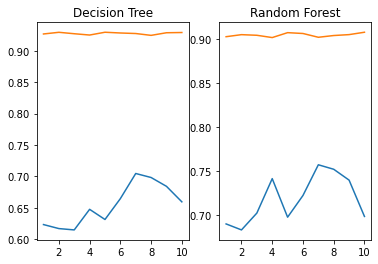

In [46]:
DT_clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=2900,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
RF_clf = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=1600,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None)

from sklearn.model_selection import cross_validate

dt_results = cross_validate(DT_clf, X, y, return_train_score=True, cv=10)
rf_results = cross_validate(RF_clf, X, y, return_train_score=True,cv=10)


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot([1,2,3,4,5,6,7,8,9,10],dt_results['test_score'], label='Validation Acc.')
ax1.plot([1,2,3,4,5,6,7,8,9,10],dt_results['train_score'], label='Training Acc.')
ax1.set_title("Decision Tree")

ax2.plot([1,2,3,4,5,6,7,8,9,10],rf_results['test_score'], label='Training Acc.')
ax2.plot([1,2,3,4,5,6,7,8,9,10],rf_results['train_score'], label='Validation Acc.')
ax2.set_title("Random Forest")